<a href="https://colab.research.google.com/github/Alterise/ML-Labs/blob/main/gradient_descent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Терешков А. Ю. \\
Группа 114

## ТЗ:

*   Выбрать тестовые функции оптимизации (2 шт)
*   Запрограммировать собственную реализацию классического градиентного спуска
*   Запрограммировать пайплайн тестирования алгоритма оптимизации
  *   Визуализации функции и точки оптимума
  *   Вычисление погрешности найденного решения в сравнение с аналитическим для нескольких запусков
  *   Визуализации точки найденного решения (можно добавить анимацию на плюс балл)
*   Запрограммировать метод вычисления градиента
  *   Передача функции градиента от пользователя
  *   Символьное вычисление градиента (например с помощью sympy) (на доп балл)
  *   Численная аппроксимация градиента (на доп балл)
*   Запрограммировать одну моментную модификацию и протестировать ее
*   Запрограммировать одну адаптивную модификацию и протестировать ее
*   Запрограммировать метод эфолюции темпа обучения и/или метод выбора начального приближения и протестировать их

## Выбрать тестовые функции оптимизации (2 шт)

Выбранные функции:
1. Функция Била \\
$f(x,y) = (1.5-x+xy)^2 + (2.25 - x + xy^2)^2 + (2.625 - x + xy^3)^2$
2. Функция Леви N 13 \\
$f(x,y) = sin^23\pi x + (x- 1)^2(1+sin^23\pi y) + (y - 1)^2 (1 + sin^2 \pi y)$

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# функция Била
def bil_function(x, y):
    return (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2

# градиент функции Била
def bil_grad(x, y):
    dx = 2*x * (y**6 + y**4 - 2*y**3 - y**2 - 2*y + 3) + 5.25*y**3 + 4.5*y**2 + 3*y - 12.75
    dy = 6*x * (x * (y**5 + 2/3*y**3 - y**2 - 1/3*y - 1/3) + 2.625*y**2 + 1.5*y + 0.5)
    return np.array([dx, dy])

# функция Леви N 13
def levi_function(x,y):
    return np.sin(3*np.pi*x)**2+(x-1)**2*(1+np.sin(1+np.sin(3*np.pi*y)**2))+(y-1)**2*(1+np.sin(np.pi*y)**2)

# градиент Леви N 13
def levi_grad(x, y):
    dx = 2 * (x - 1) * (np.sin(np.sin(3 * np.pi * y)**2 + 1) + 1) + 6 * np.pi * np.sin(3 * np.pi * x) * np.cos(3 * np.pi * x)
    dy = 6 * np.pi * (x - 1)**2 * np.sin(3 * np.pi * y) * np.cos(3 * np.pi * y) * np.cos(np.sin(3 * np.pi * y)**2 + 1) + 2 * (y - 1) * (np.sin(np.pi * y)**2 + 1) + 2 * np.pi * (y - 1)**2 * np.sin(np.pi * y) * np.cos(np.pi * y)
    return np.array([dx, dy])

# границы
x_min_bil = -4.5
x_max_bil = 4.5
y_min_bil = -4.5
y_max_bil = 4.5

x_min_levi = -10.0
x_max_levi = 10.0
y_min_levi = -10.0
y_max_levi = 10.0

## визуализация выбранных функций

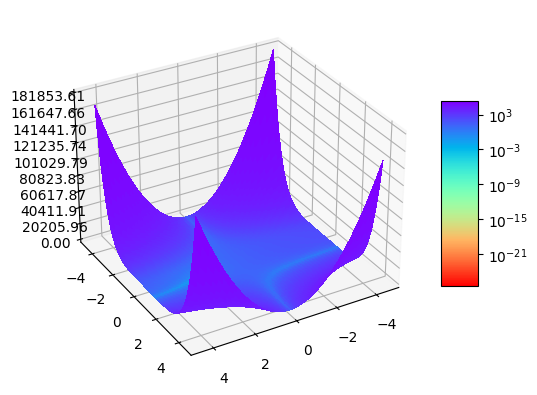

In [3]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt

x = np.arange(x_min_bil,x_max_bil,0.1)
y = np.arange(y_min_bil,y_max_bil,0.1)
X,Y = np.meshgrid(x, y)
Z = bil_function(X, Y)

fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
ax.view_init(30, 60)
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, linewidth=0, antialiased=False, cmap = cm.rainbow_r, norm=colors.LogNorm(vmin=Z.min(), vmax=Z.max()))

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

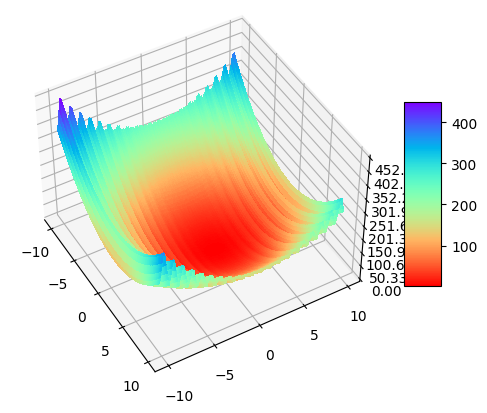

In [4]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt

x = np.arange(x_min_levi,x_max_levi,0.1)
y = np.arange(y_min_levi,y_max_levi,0.1)
X,Y = np.meshgrid(x, y)
Z = levi_function(X, Y)

fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
ax.view_init(45, -30)
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, linewidth=0, antialiased=False, cmap = cm.rainbow_r)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

##Запрограммировать собственную реализацию классического градиентного спуска

In [60]:
# градиентный спуск
def gradient_descent(function, grad_function, start_point, learning_rate = 0.02, iterations = 1000, tolerance = 1e-6):
    path = [start_point]
    x, y = start_point

    for _ in range(iterations):
        grad = grad_function(x, y)
        new_x, new_y = np.array([x, y]) - learning_rate * grad
        path.append((new_x, new_y))

        if np.linalg.norm([new_x - x, new_y - y]) < tolerance:
            break

        x, y = new_x, new_y

    return np.array(path), function(x, y)

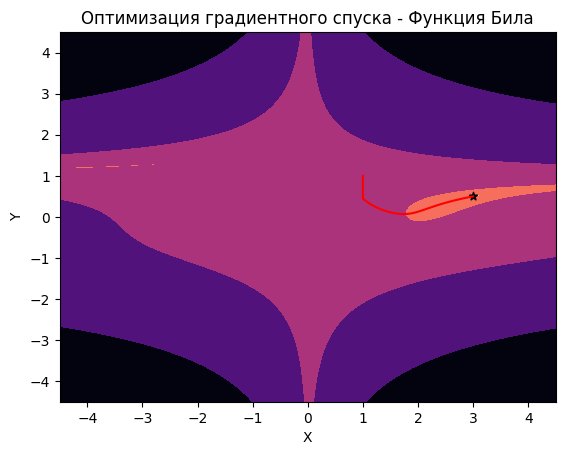

In [80]:
# визуализация (функция Била)
start_point = np.array([1, 1])

path, final_value = gradient_descent(bil_function, bil_grad, start_point)

x = np.linspace(x_min_bil, x_max_bil, 400)
y = np.linspace(y_min_bil, y_max_bil, 400)
X, Y = np.meshgrid(x, y)
Z = bil_function(X, Y)

plt.figure()
plt.title(f'Оптимизация градиентного спуска - Функция Била')
plt.contourf(X, Y, Z, cmap = cm.magma_r, norm=colors.LogNorm(vmin=Z.min(), vmax=Z.max()))
plt.plot(path[:, 0], path[:, 1], color = 'red')
plt.scatter(path[-1, 0], path[-1, 1], marker = "*", color = 'black')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

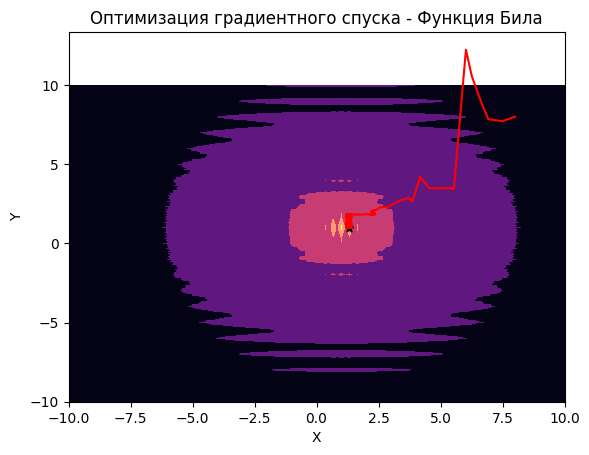

In [81]:
# визуализация (функция Леви N 13)
start_point = np.array([8, 8])

path, final_value = gradient_descent(levi_function, levi_grad, start_point)

x = np.linspace(x_min_levi, x_max_levi, 400)
y = np.linspace(y_min_levi, y_max_levi, 400)
X, Y = np.meshgrid(x, y)
Z = levi_function(X, Y)

plt.figure()
plt.title(f'Оптимизация градиентного спуска - Функция Била')
plt.contourf(X, Y, Z, cmap = cm.magma_r, norm=colors.LogNorm(vmin=Z.min(), vmax=Z.max()))
plt.plot(path[:, 0], path[:, 1], color = 'red')
plt.scatter(path[-1, 0], path[-1, 1], marker = "*", color = 'black')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

##Запрограммировать метод вычисления градиента

###Передача функции градиента от пользователя

In [66]:
# функция Била
x_val = float(input("x: "))
y_val = float(input("y: "))
print(f"Градиент для функции Била в точке ({x_val}, {y_val}): {bil_grad(x_val, y_val)}")

x: -3
y: 3
Градиент для функции Била в точке (-3.0, 3.0): [-4285.5  13020.75]


In [67]:
# функция Леви N 13
x_val = float(input("x: "))
y_val = float(input("y: "))
print(f"Градиент для функции Леви N 13 в точке ({x_val}, {y_val}): {levi_grad(x_val, y_val)}")

x: 5
y: -5
Градиент для функции Леви N 13 в точке (5.0, -5.0): [ 14.73176788 -12.        ]


###Символьное вычисление градиента (например с помощью sympy) (на доп балл)

In [68]:
import sympy as sp

x, y = sp.symbols('x y')
sympy_bil = (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2

sympy_grad = [sp.diff(sympy_bil, var) for var in (x, y)]

sympy_grad_func = sp.lambdify((x, y), sympy_grad, 'numpy')

x_val = -3
y_val = 3
sympy_grad_res = sympy_grad_func(x_val, y_val)
print(f"Символьное вычисление градиента функции Била в ({x_val}, {y_val}): {sympy_grad_res}")

Символьное вычисление градиента функции Била в (-3, 3): [-4285.5, 13020.75]


In [69]:
x, y = sp.symbols('x y')
sympy_levi = sp.sin(3*sp.pi*x)**2+(x-1)**2*(1+sp.sin(1+sp.sin(3*sp.pi*y)**2))+(y-1)**2*(1+sp.sin(sp.pi*y)**2)

sympy_grad = [sp.diff(sympy_levi, var) for var in (x, y)]

sympy_grad_func = sp.lambdify((x, y), sympy_grad, 'numpy')

x_val = 5
y_val = -5
sympy_grad_res = sympy_grad_func(x_val, y_val)
print(f"Символьное вычисление градиента функции Леви N 13 в ({x_val}, {y_val}): {sympy_grad_res}")

Символьное вычисление градиента функции Леви N 13 в (5, -5): [14.73176787846307, -11.999999999998984]


###Численная аппроксимация градиента (на доп балл)

In [70]:
def approx_grad(function, x, y, epsilon=1e-10):
    df_dx = (function(x + epsilon, y) - function(x - epsilon, y)) / (2 * epsilon)
    df_dy = (function(x, y + epsilon) - function(x, y - epsilon)) / (2 * epsilon)
    return df_dx, df_dy

x_val = -3
y_val = 3
approx_grad_res = approx_grad(bil_function, x_val, y_val)
print(f"Численная аппроксимация градиента функции Била в ({x_val}, {y_val}): {approx_grad_res}")

x_val = 5
y_val = -5
approx_grad_res = approx_grad(levi_function, x_val, y_val)
print(f"Численная аппроксимация градиента функции Леви N 13 в ({x_val}, {y_val}): {approx_grad_res}")

Численная аппроксимация градиента функции Била в (-3, 3): (-4285.502654965967, 13020.753613091074)
Численная аппроксимация градиента функции Леви N 13 в (5, -5): (14.731753594787733, -12.000000992884452)
